In [1]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras-rl2

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler

import gym
from gym import spaces

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import GreedyQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from keras.callbacks.callbacks import LambdaCallback
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [0]:
arquivo = pd.read_csv( caminho_drive + 'consolidado.csv' )
colunas = arquivo.columns
val_arquivo = arquivo[['preco', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP']]
datas_pd = arquivo[['dt', 'hr_int']]
datas_np = arquivo.rename_axis('ID').values
indexes_primeiro_do_dia = datas_pd[ datas_pd['hr_int'] == 32700000 ].index
scaler = StandardScaler().fit( val_arquivo )
valores_norm = scaler.transform( val_arquivo )

In [0]:
def cria_modelo(n_acoes, input_shape, porc_dropout):

    rna = models.Sequential()
    rna.add(layers.Flatten(input_shape=input_shape))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(64,activation='relu', kernel_constraint=max_norm(3)))
    rna.add(layers.Dropout(porc_dropout))

    rna.add(layers.Dense(n_acoes, activation='softmax'))

    return rna

In [0]:
class TradeEnv(gym.Env):
    def __init__(self, n_parametros, input_shape, max_val, min_val, val_arquivo):
        self.n_acoes = 3
        self.n_parametros = n_parametros
        self.action_space = spaces.Discrete(self.n_acoes)
        self.observation_space = spaces.Box( low=min_val , high=max_val , shape=input_shape )
        self.n_contratos = None
        self.n_contratos_ant = None
        self.n_max_contratos = 1
        self.val_carteira = None
        self.val_compra = None
        self.step_arquivo = None
        self.valores = val_arquivo
        self.step_ini = None
        self.step_fim = None
        self.reset()

    def observacao(self):
        obs = []

        for valor in self.valores[ self.step_arquivo ]:
            obs.append( valor )

        return obs

    def step(self, acao):
        self.n_contratos_ant = self.n_contratos
        acabou = None
        recompensa = 0
        valor = 0
        valor_ant = 0
        valor_dif = 0

        if self.step_arquivo + 1 == self.step_fim:
            acabou = True
            if self.n_contratos > 0:
                self.n_contratos = 0
        else:
            acabou = False

            val_linha = self.valores[ self.step_arquivo ]
            valor = val_linha[0]

            val_linha_ant = self.valores[ self.step_arquivo - 1 ]
            valor_ant = val_linha_ant[0]
            if self.step_arquivo - 1 < self.step_ini:
                valor_ant = valor

            valor_dif = valor - valor_ant #diferenca de preco

            if acao == 1: #compra
                if self.n_contratos < self.n_max_contratos:
                    self.val_compra = valor
                    self.n_contratos += 1
                    #recompensa = -valor_dif #comprou quando subiu ruim, comprou quando desceu bom
            elif acao == 2: #vende
                if self.n_contratos > 0:
                    self.n_contratos -= 1
                    recompensa = valor - self.val_compra #diferenca entre valor de compra e
                    self.val_carteira *= valor / self.val_compra
            #elif acao == 0: #nao faz nada
            #    if self.n_contratos > 0:
            #        recompensa = valor_dif #caso tenha contrato, o ganho é a diferenca dos precos
            #    else:
            #        recompensa = -valor_dif #caso nao tenha contrato, o ganho é o negativo da diferenca dos precos

            self.step_arquivo += 1

        dicionario = {'valor_norm':valor, 'valor_ant_norm':valor_ant, 'n_contratos':self.n_contratos, 'carteira':self.val_carteira, 'valor_dif':valor_dif, 'val_compra':self.val_compra}
        if self.val_compra == 0:
            dicionario['val_dif_porc'] = 0
        else:
            dicionario['val_dif_porc'] = valor / self.val_compra
        return self.observacao(), recompensa, acabou, dicionario

    def reset(self):
        self.n_contratos = 0
        self.n_contratos_ant = 0
        self.val_carteira = 100
        index_dia = np.random.choice( len(indexes_primeiro_do_dia) )
        self.step_arquivo = indexes_primeiro_do_dia[ index_dia ]
        self.step_ini = self.step_arquivo
        if index_dia + 1 == len(indexes_primeiro_do_dia):
            self.step_fim = len(self.valores)
        else:
            self.step_fim = indexes_primeiro_do_dia[ index_dia + 1 ]
        self.val_compra = 0
        return self.observacao()

    def render(self, mode='human'):
        print( '{}'.format( self.val_carteira ) )

In [169]:
np.random.seed(10)

n_parametros = len(valores_norm[0]) #define o numero de entradas da rede
janela_aprendizado = 10 #quantas linhas da memoria vai pegar pra treinar o modelo por vez
input_shape = ( janela_aprendizado, n_parametros, )
max_val_norm = np.amax( valores_norm )
min_val_norm = np.amin( valores_norm )
ambiente = TradeEnv( n_parametros , input_shape , max_val_norm , min_val_norm , valores_norm ) #cria o ambiente para o jogo
n_acoes = ambiente.n_acoes #define o numero de saidas da rede

n_steps_1 = 10000
n_steps_2 = 10000
n_steps_aquecimento = int(n_steps / 1000)
if n_steps_aquecimento < 100:
    n_steps_aquecimento = 100

memoria = SequentialMemory(limit=50000, window_length=janela_aprendizado)

modelo = cria_modelo( 3, input_shape, 0.3 )
metricas = ['accuracy']

n_steps_1_por_1000 = int(n_steps_1 / 1000)
n_steps_2_por_1000 = int(n_steps_2 / 1000)
agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_') #horario de brasilia UTC-3
caminho_export = '{0}{1}_{2}k_{3}k_steps_'.format( caminho_drive, agora, n_steps_1_por_1000, n_steps_2_por_1000 )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [170]:
eps_max = 1
eps_min = 0
politica = LinearAnnealedPolicy( inner_policy=EpsGreedyQPolicy(), attr='eps', value_max=eps_max, value_min=eps_min, nb_steps=n_steps_1, value_test=0 ) #0.2 antes do decay
agente = DQNAgent( model=modelo, policy=politica, nb_actions=n_acoes, memory=memoria, enable_double_dqn=True, test_policy=GreedyQPolicy(), nb_steps_warmup=n_steps_aquecimento )
agente.compile(optimizers.Adam(), metrics=metricas)

resultados_treino = []
intervalo_log_1 = int( n_steps_1 / 5 )
intervalo_modelo_1 = int( n_steps_1 / 5 )
callbacks_treino_1 = []
callbacks_treino_1.append( FileLogger( 'log_1.log' ) )
callbacks_treino_1.append( FileLogger( '{0}log_1.log'.format( caminho_export ) ) )
callbacks_treino_1.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_1.append( ModelIntervalCheckpoint( '{0}dqn_1.h5f'.format( caminho_export ) , interval=intervalo_modelo_1 ) )
historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=1, callbacks=callbacks_treino_1, log_interval=intervalo_log_1)
#historia_treino = agente.fit(env=ambiente, nb_steps=n_steps_1, visualize=False, verbose=0, callbacks=callbacks_treino_1)

agente.save_weights('dqn_1.h5f', overwrite=True)
#agente.save_weights( '{0}dqn_1.h5f'.format( caminho_export ), overwrite=True )

Training for 10000 steps ...
Interval 1 (0 steps performed)
2000/2000 [==============================] - 33s 17ms/step - reward: 3.9541e-04
18 episodes - episode_reward: 0.042 [-0.214, 0.298] - loss: 0.004 - accuracy: 0.336 - mean_q: 0.350 - mean_eps: 0.895 - valor_norm: -0.215 - valor_ant_norm: -0.215 - n_contratos: 0.460 - carteira: 265.593 - valor_dif: 0.000 - val_compra: -0.208 - val_dif_porc: 1.082

Interval 2 (2000 steps performed)
2000/2000 [==============================] - 35s 18ms/step - reward: 4.3170e-04
19 episodes - episode_reward: 0.037 [-0.092, 0.275] - loss: 0.004 - accuracy: 0.395 - mean_q: 0.348 - mean_eps: 0.700 - valor_norm: -0.190 - valor_ant_norm: -0.190 - n_contratos: 0.320 - carteira: 175.497 - valor_dif: -0.000 - val_compra: -0.187 - val_dif_porc: 0.991

Interval 3 (4000 steps performed)
2000/2000 [==============================] - 33s 16ms/step - reward: -1.7383e-04
19 episodes - episode_reward: -0.014 [-0.145, 0.160] - loss: 0.003 - accuracy: 0.462 - mean_q:

In [171]:
agente = DQNAgent( model=modelo, policy=GreedyQPolicy(), nb_actions=n_acoes, memory=memoria )
agente.compile(optimizers.Adam(), metrics=metricas)
agente.load_weights('dqn_1.h5f')

intervalo_log_2 = int( n_steps_2 / 5 )
intervalo_modelo_2 = int( n_steps_2 / 5 )
callbacks_treino_2 = []
callbacks_treino_2.append( FileLogger( 'log_2.log' ) )
callbacks_treino_2.append( FileLogger( '{0}log_2.log'.format( caminho_export ) ) )
callbacks_treino_2.append( LambdaCallback( on_batch_end=lambda batch,logs: resultados_treino.append( logs ) ) )
callbacks_treino_2.append( ModelIntervalCheckpoint( '{0}dqn_2.h5f'.format( caminho_export ) , interval=intervalo_modelo_2 ) )
historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_2, visualize=False, verbose=1, callbacks=callbacks_treino_2, log_interval=intervalo_log_2)
#historia_treino_2 = agente.fit(env=ambiente, nb_steps=n_steps_teste, visualize=False, verbose=0, callbacks=callbacks_treino_2)

agente.save_weights('dqn_2.h5f', overwrite=True)
#agente.save_weights( '{0}dqn_2.h5f'.format( caminho_export ) , overwrite=True )

Training for 10000 steps ...
Interval 1 (0 steps performed)
2000/2000 [==============================] - 19s 9ms/step - reward: -2.4832e-05
18 episodes - episode_reward: -0.003 [-0.050, 0.000] - loss: 0.001 - accuracy: 0.656 - mean_q: 0.357 - valor_norm: 0.526 - valor_ant_norm: 0.525 - n_contratos: 0.005 - carteira: 99.162 - valor_dif: 0.000 - val_compra: 0.002 - val_dif_porc: 0.020

Interval 2 (2000 steps performed)
2000/2000 [==============================] - 32s 16ms/step - reward: -8.2137e-05
19 episodes - episode_reward: -0.009 [-0.099, 0.000] - loss: 0.001 - accuracy: 0.685 - mean_q: 0.358 - valor_norm: 0.233 - valor_ant_norm: 0.233 - n_contratos: 0.024 - carteira: 100.435 - valor_dif: 0.000 - val_compra: -0.044 - val_dif_porc: 0.058

Interval 3 (4000 steps performed)
2000/2000 [==============================] - 32s 16ms/step - reward: 1.9102e-06
19 episodes - episode_reward: 0.000 [-0.008, 0.015] - loss: 0.001 - accuracy: 0.716 - mean_q: 0.359 - valor_norm: 0.164 - valor_ant_nor

In [157]:
qnt_val = 0
for log in resultados_treino:
    if not math.isnan( log['metrics'][0] ):
        print('valor = {:.4f}, valor_ant = {:.4f}, acao = {}, episodio = {}, n_contratos = {}, carteira = {:.4f}, valor_dif = {:.4f}'.format(log['info']['valor_norm'], log['info']['valor_ant_norm'], log['action'], log['episode'], log['info']['n_contratos'], log['info']['carteira'], log['info']['valor_dif']))
        qnt_val += 1
    if qnt_val > 10:
        break

valor = -0.9050, valor_ant = -0.9164, acao = 1, episodio = 0, n_contratos = 1, carteira = 99.4703, valor_dif = 0.0115
valor = -0.9355, valor_ant = -0.9050, acao = 0, episodio = 0, n_contratos = 1, carteira = 99.4703, valor_dif = -0.0306
valor = -0.9202, valor_ant = -0.9355, acao = 0, episodio = 0, n_contratos = 1, carteira = 99.4703, valor_dif = 0.0153
valor = -0.9088, valor_ant = -0.9202, acao = 0, episodio = 0, n_contratos = 1, carteira = 99.4703, valor_dif = 0.0115
valor = 0.0000, valor_ant = 0.0000, acao = 1, episodio = 0, n_contratos = 0, carteira = 99.4703, valor_dif = 0.0000
valor = 0.0921, valor_ant = 0.0921, acao = 2, episodio = 1, n_contratos = 0, carteira = 100.0000, valor_dif = 0.0000
valor = 0.1074, valor_ant = 0.0921, acao = 0, episodio = 1, n_contratos = 0, carteira = 100.0000, valor_dif = 0.0153
valor = 0.1456, valor_ant = 0.1074, acao = 0, episodio = 1, n_contratos = 0, carteira = 100.0000, valor_dif = 0.0382
valor = 0.1113, valor_ant = 0.1456, acao = 1, episodio = 1, 

IndexError: ignored

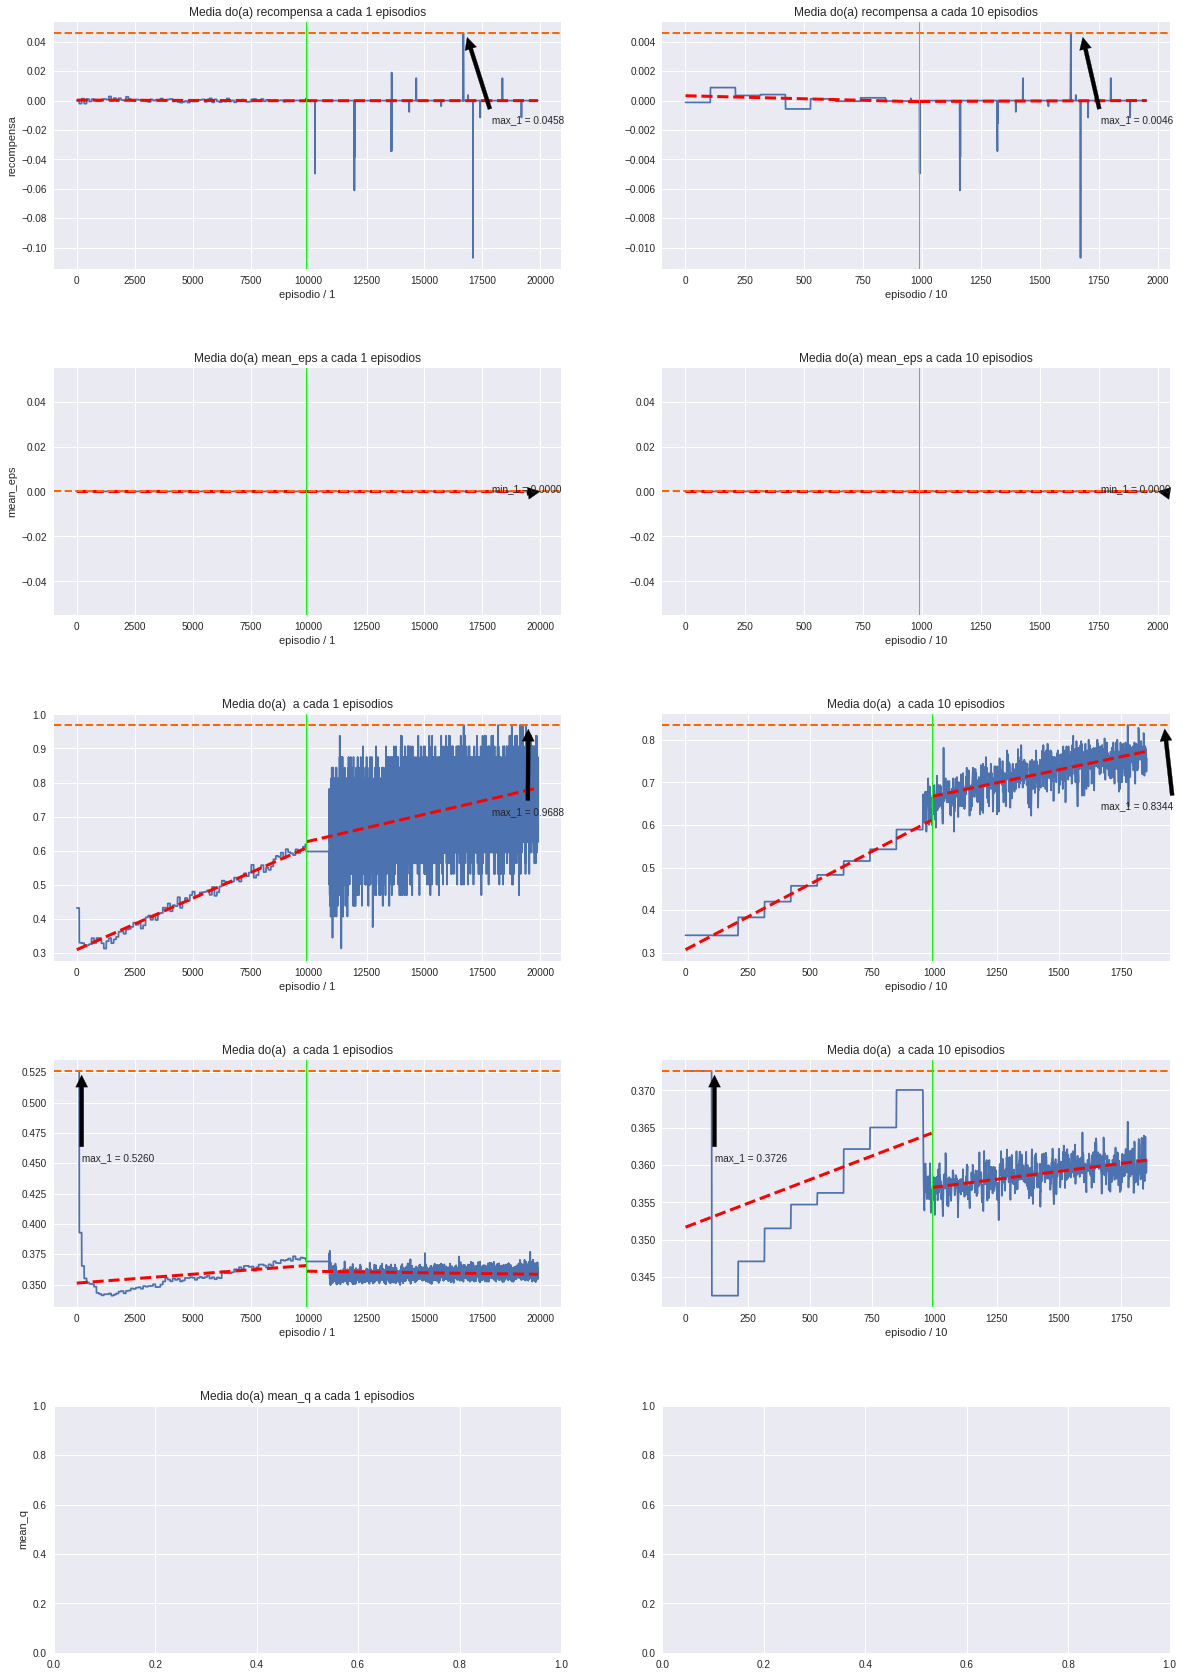

In [178]:
plt.style.use('seaborn')
#nm_metricas = ['recompensa', 'regret', 'loss', 'accuracy', 'mean_q', 'mean_eps']
#nm_metricas = ['recompensa', 'loss', 'accuracy', 'mean_q', 'mean_eps']
nm_metricas = ['recompensa', 'mean_eps', '', '', 'mean_q']
metrica_max = [True, False, True, True, False]
divisores = [1, 10]
result = resultados_treino
n_resultados = len(result)
tipo = 'treino_full'
pular_n_steps = n_steps_aquecimento
fig_size_x = 20
fig_size_y = len(nm_metricas) * 6

fig, axs = plt.subplots(len(nm_metricas), len(divisores), gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=( fig_size_x , fig_size_y ))
#fig.suptitle('Medias por episodios do {}'.format(tipo))
for metrica_i in range(len(nm_metricas)):

    nm_metrica = nm_metricas[metrica_i]
    if len(divisores) == 1:
        axs[metrica_i].set(ylabel=nm_metrica)
    else:
        axs[metrica_i][0].set(ylabel=nm_metrica)
    grafico = 0

    for divisor in divisores:

        axes = None
        if len(divisores) == 1:
            axes = axs[metrica_i]
        else:
            axes = axs[metrica_i][grafico]
        grafico = 0
        axes.set(title='Media do(a) {} a cada {} episodios'.format(nm_metrica, divisor))

        hist_metricas = []
        metricas_media = []
        metricas_ref = []
        ref = result[pular_n_steps]['episode']

        # [ posicao em x do maior ponto na media , posicao y do maior ponto na media , maior ponto ]
        max_metrica_media_1 = [None, None]
        min_metrica_media_1 = [None, None]

        for i in range(0, n_resultados + 1):
            if len(hist_metricas) % divisor == 0 and len(hist_metricas) > 0:
                metricas_media.append( sum(hist_metricas[-divisor:]) / divisor )
                #pega maximos e minimos
                if max_metrica_media_1[1] == None or metricas_media[-1] >= max_metrica_media_1[1]:
                    max_metrica_media_1[0] = i / divisor
                    max_metrica_media_1[1] = metricas_media[-1]
                if min_metrica_media_1[1] == None or metricas_media[-1] <= min_metrica_media_1[1]:
                    min_metrica_media_1[0] = i / divisor
                    min_metrica_media_1[1] = metricas_media[-1]
            if (i == n_resultados or result[i]['episode'] != ref) and len(metricas_ref) > 0:
                hist_metricas.append( sum(metricas_ref) / len(metricas_ref) )
                ref += 1
                metricas_ref = []
            if i < n_resultados:
                if metrica_i == 0: #recompensa
                    metricas_ref.append( result[i]['reward'] )
                #elif metrica_i == 1: #regret
                #    metricas_ref.append( result[i]['info']['recompensa_max'] - result[i]['reward'] )
                else: #outras metricas
                    if metrica_i - 1 == len(result[i]['metrics']): #se for o epsilon
                        metricas_ref.append( 0 )
                    else:
                        if not math.isnan( result[i]['metrics'][metrica_i-1] ): #tem que ser diferente de Not a Number (NaN)
                            metricas_ref.append( result[i]['metrics'][metrica_i-1] )

        n_steps_media_treino_1 = int((n_steps_1 - pular_n_steps) / divisor)
        n_steps_media_total = len(metricas_media)
        #plota grafico
        x_plot = np.arange(n_steps_media_total)
        axes.set(xlabel='episodio / {}'.format(divisor))
        axes.plot(x_plot, metricas_media)
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[:n_steps_media_treino_1], metricas_media[:n_steps_media_treino_1], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[:n_steps_media_treino_1], p(x_plot[:n_steps_media_treino_1]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps decay')
        #linha de tendencia antes do epsilon = 0
        z = np.polyfit(x_plot[n_steps_media_treino_1:], metricas_media[n_steps_media_treino_1:], 1)
        p = np.poly1d(z)
        axes.plot(x_plot[n_steps_media_treino_1:], p(x_plot[n_steps_media_treino_1:]), c='#ff0000', ls="--", linewidth=3, label='tendencia eps = 0')
        #maximo e minimo
        if metrica_max[metrica_i]:
            #linha de maximo_1
            anotacao_x_max = max_metrica_media_1[0]
            if max_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_max = n_steps_media_total * 0.9
            anotacao_y_max = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.6) + min_metrica_media_1[1]
            axes.axhline(max_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='maximo_1')
            axes.annotate( 'max_1 = {:.4f}'.format(max_metrica_media_1[1]), 
                                            xy=( max_metrica_media_1[0] , max_metrica_media_1[1] ),
                                            xytext=( anotacao_x_max , anotacao_y_max ),
                                            arrowprops=dict(facecolor='black', shrink=0.05) )
        else:
            #linha de minimo_1
            anotacao_x_min = min_metrica_media_1[0]
            if min_metrica_media_1[0] > n_steps_media_total / 2:
                anotacao_x_min = n_steps_media_total * 0.9
            anotacao_y_min = ((max_metrica_media_1[1] - min_metrica_media_1[1]) * 0.4) + min_metrica_media_1[1]
            axes.axhline(min_metrica_media_1[1], c='#ff6600', ls='--', linewidth=2, label='minimo_1')
            axes.annotate( 'min_1 = {:.4f}'.format(min_metrica_media_1[1]),
                                            xy=( min_metrica_media_1[0] , min_metrica_media_1[1] ),
                                            xytext=( anotacao_x_min , anotacao_y_min ),
                                            arrowprops=dict(facecolor='black', shrink=0.03) )
        #linha do epsilon = 0
        axes.axvline( x=n_steps_media_treino_1, c='#00ff00' , linewidth=1, label='epsilon = 0')
        
        grafico += 1

fig.show()
fig.savefig('result_{}.png'.format(tipo), bbox_inches='tight') #salva o grafico em uma foto
#fig.savefig('{0}result_{1}.png'.format( caminho_export, tipo ), bbox_inches='tight') #salva o grafico em uma foto

In [166]:
retorno = agente.test(ambiente, nb_episodes=1, verbose=1, visualize=True)

Testing for 1 episodes ...
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
Episode 1: reward: 0.000, steps: 106
